In [2]:
!pip install mxnet

    100% |████████████████████████████████| 27.1MB 1.4MB/s 
    100% |████████████████████████████████| 61kB 18.6MB/s 
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
google-colab 0.0.1a1 has requirement requests~=2.18.0, but you'll have requests 2.21.0 which is incompatible.
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Found existing installation: requests 2.18.4
    Uninstalling requests-2.18.4:
      Successfully uninstalled requests-2.18.4


In [0]:
from __future__ import print_function
import mxnet as mx
import mxnet.ndarray as nd
from mxnet import autograd
import numpy as np
ctx = mx.cpu()
mx.random.seed(1)


# for plotting purposes
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [0]:
mnist = mx.test_utils.get_mnist()
num_examples = 1000
batch_size = 64
train_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["train_data"][:num_examples],
                               mnist["train_label"][:num_examples].astype(np.float32)),
                               batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["test_data"][:num_examples],
                               mnist["test_label"][:num_examples].astype(np.float32)),
                               batch_size, shuffle=False)

In [0]:
W = nd.random_normal(shape=(784,10))
b = nd.random_normal(shape=10)

params = [W, b]

for param in params:
    param.attach_grad()

def net(X):
    y_linear = nd.dot(X, W) + b
    yhat = nd.softmax(y_linear, axis=1)
    return yhat

In [0]:

def cross_entropy(yhat, y):
    return - nd.sum(y * nd.log(yhat), axis=0, exclude=True)

def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [0]:

def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    loss_avg = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        output = net(data)
        loss = cross_entropy(output, label_one_hot)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return (numerator / denominator).asscalar(), loss_avg

In [0]:
def plot_learningcurves(loss_tr,loss_ts, acc_tr,acc_ts):
    xs = list(range(len(loss_tr)))

    f = plt.figure(figsize=(12,6))
    fg1 = f.add_subplot(121)
    fg2 = f.add_subplot(122)

    fg1.set_xlabel('epoch',fontsize=14)
    fg1.set_title('Comparing loss functions')
    fg1.semilogy(xs, loss_tr)
    fg1.semilogy(xs, loss_ts)
    fg1.grid(True,which="both")

    fg1.legend(['training loss', 'testing loss'],fontsize=14)

    fg2.set_title('Comparing accuracy')
    fg1.set_xlabel('epoch',fontsize=14)
    fg2.plot(xs, acc_tr)
    fg2.plot(xs, acc_ts)
    fg2.grid(True,which="both")
    fg2.legend(['training accuracy', 'testing accuracy'],fontsize=14)

Completed epoch 100. Train Loss: 0.019331166753545407, Test Loss 1.0836375504732132, Train_acc 1.0, Test_acc 0.784
Completed epoch 200. Train Loss: 0.01718458096729592, Test Loss 1.0814352296292784, Train_acc 1.0, Test_acc 0.79
Completed epoch 300. Train Loss: 0.015700633521191776, Test Loss 1.0796548165380955, Train_acc 1.0, Test_acc 0.79
Completed epoch 400. Train Loss: 0.014304113399703056, Test Loss 1.0782862976193426, Train_acc 1.0, Test_acc 0.79
Completed epoch 500. Train Loss: 0.013226475595729426, Test Loss 1.0772921331226821, Train_acc 1.0, Test_acc 0.792
Completed epoch 600. Train Loss: 0.012200058088637892, Test Loss 1.0764516144990919, Train_acc 1.0, Test_acc 0.793
Completed epoch 700. Train Loss: 0.011486346076708287, Test Loss 1.0758792124688628, Train_acc 1.0, Test_acc 0.794
Completed epoch 800. Train Loss: 0.010833404026925564, Test Loss 1.0754708051681519, Train_acc 1.0, Test_acc 0.796
Completed epoch 900. Train Loss: 0.010033839207608254, Test Loss 1.0751810148358345,

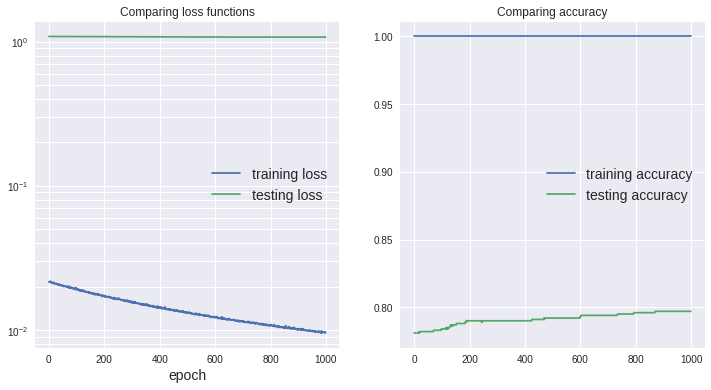

In [10]:


epochs = 1000
moving_loss = 0.
niter=0

loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []


for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, .001)

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(loss).asscalar()
        est_loss = moving_loss/(1-0.99**niter)

    test_accuracy, test_loss = evaluate_accuracy(test_data, net)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)


    if e % 100 == 99:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))


## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)

In [0]:
def l2_penalty(params):
    penalty = nd.zeros(shape=1)
    for param in params:
        penalty = penalty + nd.sum(param ** 2)
    return penalty

Completed epoch 100. Train Loss: 0.02706680347910151, Test Loss 0.8382959738373756, Train_acc 1.0, Test_acc 0.801
Completed epoch 200. Train Loss: 0.05391096172388642, Test Loss 0.6804888732731341, Train_acc 1.0, Test_acc 0.807
Completed epoch 300. Train Loss: 0.08156323013827206, Test Loss 0.5849561225622892, Train_acc 1.0, Test_acc 0.82
Completed epoch 400. Train Loss: 0.10164770181290807, Test Loss 0.5344529245048762, Train_acc 0.998, Test_acc 0.825
Completed epoch 500. Train Loss: 0.11416564323008062, Test Loss 0.5099588073790073, Train_acc 0.997, Test_acc 0.834
Completed epoch 600. Train Loss: 0.1218679123558104, Test Loss 0.5006178915500641, Train_acc 0.997, Test_acc 0.838
Completed epoch 700. Train Loss: 0.12547990307211876, Test Loss 0.49766224250197394, Train_acc 0.994, Test_acc 0.841
Completed epoch 800. Train Loss: 0.12810003710910678, Test Loss 0.4956601634621621, Train_acc 0.994, Test_acc 0.841
Completed epoch 900. Train Loss: 0.12700896570459008, Test Loss 0.4964063987135

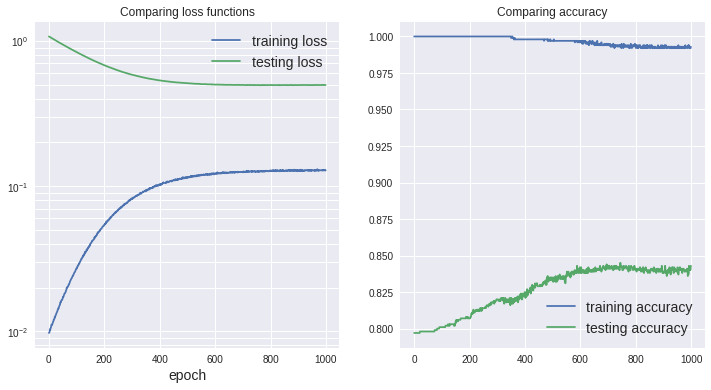

In [12]:
epochs = 1000
moving_loss = 0.
l2_strength = .1
niter=0

loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []


for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = nd.sum(cross_entropy(output, label_one_hot)) + l2_strength * l2_penalty(params)
        loss.backward()
        SGD(params, .001)

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(loss).asscalar()
        est_loss = moving_loss/(1-0.99**niter)


    test_accuracy, test_loss = evaluate_accuracy(test_data, net)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)

    if e % 100 == 99:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))


## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)